In [1]:
# Import Data

In [2]:
import itertools
import os
# plt.style.use('ggplot')
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
# from keras.callbacks import ModelCheckpoint, CSVLogger
# from keras.layers import Dense, Dropout, LSTM, Input
# from keras.models import Model
# from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, Activation
# from keras.callbacks import EarlyStopping

filterwarnings('ignore')
# % matplotlib
# inline

c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\ten

In [3]:
# set data folder path
# DATA_FOLDER = r'./MAREA_dataset'

DATA_FOLDER = r'D:/NUS_TERM2_CA3/MAREA_dataset'
ACTIVITY_FOLDER = os.path.join(DATA_FOLDER, 'Activity Timings')
SUBJECT_FOLDER = os.path.join(DATA_FOLDER, 'Subject Data_txt format')
PROCESSED_FOLDER = os.path.join(DATA_FOLDER, 'Processed_data')

# define activity timing labels
label_indoor = ['tread_flat_walk_start',
                'tread_flat_walk_end',
                'tread_flat_run_end',
                'tread_slope_walk_start',
                'tread_slope_walk_end',
                'indoor_flat_walk_start',
                'indoor_flat_walk_end',
                'indoor_flat_run_end']

label_outdoor = ['outdoor_walk_start',
                 'outdoor_walk_end',
                 'outdoor_run_end']

# prepare timing index for different activities
df_indoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Indoor Experiment Timings.txt')
                             , names=label_indoor)

df_outdoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Outdoor Experiment Timings.txt')
                              , names=label_outdoor)

df_indoor_time["subject"] = ["Sub" + str(i) for i in range(1, 12)]
df_outdoor_time["subject"] = ["Sub" + str(j) for j in range(12, 21)]

In [4]:
# set up activity column names
axis_list = ['accX', 'accY', 'accZ']
pos_list = ['LF', 'RF', 'Waist', 'Wrist']
sub_list = ['Sub' + str(i) for i in range(1, 21)]
column_names = [f"{y}_{x}" for x, y in itertools.product(pos_list, axis_list)]

# TODO: purposely exclude subject 4 first as missing data -- dont know how to deal with missing data for signal
sub_list.remove('Sub4')

In [5]:
column_names

['accX_LF',
 'accY_LF',
 'accZ_LF',
 'accX_RF',
 'accY_RF',
 'accZ_RF',
 'accX_Waist',
 'accY_Waist',
 'accZ_Waist',
 'accX_Wrist',
 'accY_Wrist',
 'accZ_Wrist']

In [6]:
# create master dataframe
const_master_df = pd.DataFrame()
for sub in sub_list:
    df_lf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'LF.txt'))
    df_rf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'RF.txt'))
    df_waist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Waist.txt'))
    df_wrist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Wrist.txt'))
    df_sub = pd.concat([df_lf, df_rf, df_waist, df_wrist], axis=1)
    df_sub.columns = column_names

    df_sub = df_sub.copy()
    n = int(sub[3:])
    if n > 11:
        sub_row = df_outdoor_time[df_outdoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['outdoor_walk_end'], 'label'] = 'outdoor_walk'
        df_sub.loc[tmp['outdoor_walk_end']: tmp['outdoor_run_end'], 'label'] = 'outdoor_run'
    else:
        sub_row = df_indoor_time[df_indoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['tread_flat_walk_end'], 'label'] = 'tread_flat_walk'
        df_sub.loc[tmp['tread_flat_walk_end']: tmp['tread_flat_run_end'], 'label'] = 'tread_flat_run'
        df_sub.loc[tmp['tread_flat_run_end']: tmp['tread_slope_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['tread_slope_walk_start']: tmp['tread_slope_walk_end'], 'label'] = 'tread_slope_walk'
        df_sub.loc[tmp['tread_slope_walk_end']: tmp['indoor_flat_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['indoor_flat_walk_start']: tmp['indoor_flat_walk_end'], 'label'] = 'indoor_flat_walk'
        df_sub.loc[tmp['indoor_flat_walk_end']: tmp['indoor_flat_run_end'], 'label'] = 'indoor_flat_run'

    df_sub['subject'] = sub
    const_master_df = const_master_df.append(df_sub)
    # print(df.shape)

In [7]:
const_master_df.head(5)


,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,accY_Wrist,accZ_Wrist,label,subject
0,-2.196,-11.765,-1.569,4.078,-6.902,2.196,-0.157,-8.157,0.784,0.941,-11.451,-2.510,tread_flat_walk,Sub1
1,-2.510,-10.353,-2.039,4.392,-8.000,1.255,-0.157,-8.000,1.255,0.627,-10.510,-2.353,tread_flat_walk,Sub1
2,-2.353,-10.824,-2.510,4.863,-8.314,0.941,-0.157,-7.843,1.255,0.784,-10.196,-2.039,tread_flat_walk,Sub1
3,-1.882,-10.667,-2.667,4.549,-9.412,-0.157,-0.157,-8.000,1.412,1.255,-10.039,-1.412,tread_flat_walk,Sub1
4,-1.412,-10.353,-2.824,3.451,-10.353,-0.784,-0.627,-7.529,1.882,1.569,-10.196,-1.255,tread_flat_walk,Sub1


In [8]:
def PreprocessingSignal(df, label, subject, feature, window,
                        wavelet_args={"type": "Y",
                                      "threshold": 2,
                                      "wavedec_options": {"wavelet": "db4", "level": 2},
                                      "waverec_options": {"wavelet": "db4"}},
                        window_args={"type": "no_overlap"}
                        ):
    df = df.loc[(df['label'] == label) & (df['subject'] == subject)]

    ### Do wavelet transform or NOT ###
    if wavelet_args["type"] == "Y":
        # wavelet_args = {"threshold":2, "options":{"wavelet":"db4", "level":0.8}}
        # Do wavelet transform
        signal_orig = df[feature].values
        args1 = wavelet_args["wavedec_options"]
        coeffs_orig = pywt.wavedec(signal_orig, **args1)
        coeffs_filter = coeffs_orig.copy()
        threshold = wavelet_args["threshold"]
        for i in range(1, len(coeffs_orig)):
            coeffs_filter[i] = pywt.threshold(coeffs_orig[i], threshold * max(coeffs_orig[i]))
        args2 = wavelet_args["waverec_options"]
        signal_denoised = pywt.waverec(coeffs_filter, **args2)
        to_process_df = pd.DataFrame(signal_denoised)
    else:
        tmp_df = df[feature].reset_index()
        to_process_df = tmp_df.drop(columns=["index"])
        to_process_df.columns = [0]
    ### Do wavelet transform or NOT ###

    min_index = min(to_process_df.index)
    max_index = max(to_process_df.index)

    ### Define Method to cut signal into windows ###
    if window_args["type"] == "no_overlap":
        # window_args = {"type":"no_overlap"}
        index_list = range(min_index, max_index + 1, int(window))
    elif window_args["type"] == "with_overlap":
        # window_args = {"type":"with_overlap", "overlap_perc":0.5}
        overlap_perc = window_args["overlap_perc"]
        step = int(window / (1 / overlap_perc))
        index_list = range(min_index, max_index + 1, step)
    elif window_args["type"] == "by_peaks":
        index_list = window_args["peaks_index"]
    ### Define Method to cut signal into windows ###

    ### Cut signal into windows ###
    windowed_selected_chunk_array = []
    for index in index_list:
        windowed_selected_chunk = to_process_df[0].iloc[index:index + window]
        if windowed_selected_chunk.shape[0] == window:
            windowed_selected_chunk_array.append(windowed_selected_chunk.values)
    output_np_arr = np.array(windowed_selected_chunk_array)
    ### Cut signal into windows ###

    output_np_label = np.asarray([label] * output_np_arr.shape[0])

    return output_np_arr, output_np_label


In [9]:
# feature_list = column_names TODO: is this line still needed?

# Create
const_indoor_activity = ['rest',
                         'tread_flat_walk',
                         'tread_flat_run',
                         'tread_slope_walk',
                         'indoor_flat_walk',
                         'indoor_flat_run'
                         ]
const_outdoor_activity = ['outdoor_walk', 'outdoor_run']

const_indoor_sub = ['Sub' + str(i) for i in range(1, 12)]
const_outdoor_sub = ['Sub' + str(i) for i in range(12, 21)]
const_indoor_sub.remove('Sub4')


In [10]:
def PrepareFeature(df, feature, feature_col, split_method, window, wavelet_args, window_args, train_size=0.8):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()

    # TODO: find_peaks from a given column
    # NOTE: code will break when using -> window_args = {"type":"by_peaks", "peaks_index":peaks_index_list}

    # method 1: split within each subject
    if split_method == 'TrainTestSplitWithinSubject':
        # indoor activity
        for sub in const_indoor_sub:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list

                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)

                output_train_len = int(train_size * len(output_np_arr))
                tr_x = output_np_arr[:output_train_len, :]
                ts_x = output_np_arr[output_train_len:len(output_np_arr), :]

                label_train_len = int(train_size * len(output_label))
                tr_y = output_label[:label_train_len]
                ts_y = output_label[label_train_len:len(output_label)]

                X_train = X_train.append(pd.DataFrame(tr_x))
                X_test = X_test.append(pd.DataFrame(ts_x))
                y_train = y_train.append(pd.DataFrame(tr_y))
                y_test = y_test.append(pd.DataFrame(ts_y))

                # outdoor activity
        for sub in const_outdoor_sub:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list

                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)

                output_train_len = int(train_size * len(output_np_arr))
                tr_x = output_np_arr[:output_train_len, :]
                ts_x = output_np_arr[output_train_len:len(output_np_arr), :]

                label_train_len = int(train_size * len(output_label))
                tr_y = output_label[:label_train_len]
                ts_y = output_label[label_train_len:len(output_label)]

                X_train = X_train.append(pd.DataFrame(tr_x))
                X_test = X_test.append(pd.DataFrame(ts_x))
                y_train = y_train.append(pd.DataFrame(tr_y))
                y_test = y_test.append(pd.DataFrame(ts_y))

    # method 2: split all samples randomly
    if split_method == 'Random':
        #             output = np.asarray(list())
        #             label = np.asarray(list())
        output = np.empty((0, window), float)
        label = np.empty((0,), float)

        # indoor activity
        for sub in const_indoor_sub:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                output = np.append(output, output_np_arr, axis=0)
                label = np.append(label, output_label, axis=0)

        # outdoor activity:
        for sub in const_outdoor_sub:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                output = np.append(output, output_np_arr, axis=0)
                label = np.append(label, output_label, axis=0)

    
        shuffle_index = np.arange(len(label))
        np.random.RandomState(42).shuffle(shuffle_index)

        output_train_len = int(train_size * len(output))
        tr_x = output[shuffle_index][:output_train_len, :]
        ts_x = output[shuffle_index][output_train_len:len(output), :]

        label_train_len = int(train_size * len(label))
        tr_y = label[shuffle_index][:label_train_len]
        ts_y = label[shuffle_index][label_train_len:len(label)]

        X_train = X_train.append(pd.DataFrame(tr_x))
        X_test = X_test.append(pd.DataFrame(ts_x))
        y_train = y_train.append(pd.DataFrame(tr_y))
        y_test = y_test.append(pd.DataFrame(ts_y))

    # method 3: only keep several subjects in the train,
    #           put other subjects in the test
    if split_method == 'DifferentSubjectsInTrainTest':
        train_sub = np.empty((0, window), float)
        train_label_sub = np.empty((0,), float)
        test_sub = np.empty((0, window), float)
        test_label_sub = np.empty((0,), float)

        # indoor activity
        indoor_sub_train_len = int(train_size * len(const_indoor_sub))
        indoor_sub_train = const_indoor_sub[:indoor_sub_train_len]
        indoor_sub_test = const_indoor_sub[indoor_sub_train_len:len(const_indoor_sub)]

        for sub in indoor_sub_train:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    # print("THIS", activity, peaks_index_list)
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                train_sub = np.append(train_sub, output_np_arr, axis=0)
                train_label_sub = np.append(train_label_sub, output_label, axis=0)

        for sub in indoor_sub_test:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                test_sub = np.append(test_sub, output_np_arr, axis=0)
                test_label_sub = np.append(test_label_sub, output_label, axis=0)

        # outdoor activity
        outdoor_sub_train_len = int(train_size * len(const_outdoor_sub))
        outdoor_sub_train = const_outdoor_sub[:outdoor_sub_train_len]
        outdoor_sub_test = const_outdoor_sub[outdoor_sub_train_len:len(const_outdoor_sub)]

        for sub in outdoor_sub_train:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                train_sub = np.append(train_sub, output_np_arr, axis=0)
                train_label_sub = np.append(train_label_sub, output_label, axis=0)

        for sub in outdoor_sub_test:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                test_sub = np.append(test_sub, output_np_arr, axis=0)
                test_label_sub = np.append(test_label_sub, output_label, axis=0)

        X_train = pd.DataFrame(train_sub)
        y_train = pd.DataFrame(train_label_sub)
        X_test = pd.DataFrame(test_sub)
        y_test = pd.DataFrame(test_label_sub)

    return X_train, X_test, y_train, y_test


In [11]:
# SAMPLE #

def prepare_single_feature_to_csv(feature='accY_LF', feature_col='accY_LF', model_name='v1', split_method='TrainTestSplitWithinSubject', 
                                  window=512, wavelet_args={"type": "N"},
                                  window_args={"type": "by_peaks", "find_peaks_col": "accX_LF",
                                               "find_peaks_options": {"prominence": 30, "height": 20}}):
    # feature = 'accY_LF'
    # feature_list = column_names
    # for feature in column_names:
    # (example) feature = accX_LF (which is stored in the column_names)

    X_train, X_test, y_train, y_test = PrepareFeature(const_master_df, feature, feature_col, split_method, window, wavelet_args,
                                                      window_args)

    X_train_filename = "_".join(
        ['X_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'
    X_test_filename = "_".join(
        ['X_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'
    y_train_filename = "_".join(
        ['y_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'
    y_test_filename = "_".join(
        ['y_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'

    WORK_FOLDER = r'./Models'
    MODEL_FOLDER = os.path.join(WORK_FOLDER, model_name) 
    if not os.path.exists(MODEL_FOLDER):
        os.makedirs(MODEL_FOLDER)
    
    X_train.to_csv(os.path.join(MODEL_FOLDER, X_train_filename), header=None, index=False, sep='\t')
    X_test.to_csv(os.path.join(MODEL_FOLDER, X_test_filename), header=None, index=False, sep='\t')

    pd.DataFrame(y_train).to_csv(os.path.join(MODEL_FOLDER,y_train_filename), header=None, index=False, sep='\t')
    pd.DataFrame(y_test).to_csv(os.path.join(MODEL_FOLDER,y_test_filename), header=None, index=False, sep='\t')

    print("Saved X_train to %s" % (X_train_filename))
    print("Saved X_test to %s" % (X_test_filename))
    print("Saved Y_train to %s" % (y_train_filename))
    print("Saved y_test to %s" % (y_test_filename))


In [12]:
def load_file(model_folder, filename):
    
    filepath = os.path.join(model_folder, filename)
  
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values


In [13]:
def load_group(model_folder, filenames):
    loaded = list()
    for name in filenames:
        data = load_file(model_folder, name)
        loaded.append(data)

    loaded = np.dstack(loaded)
    return loaded


In [14]:
def load_dataset(model_name, feature_list, window, wavelet_args, window_args, split_method):

    WORK_FOLDER = r'./Models'
    MODEL_FOLDER = os.path.join(WORK_FOLDER, model_name) 
    
    X_train_filenames = []
    X_test_filenames = []

    for feature in feature_list:
        X_train_filenames.append("_".join(
            ['X_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
             split_method]) + '.txt')

        X_test_filenames.append("_".join(
            ['X_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
             split_method]) + '.txt')

    # X_train_filenames = ['X_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt']
    # y_train_filename = 'y_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt'

    
    y_train_filename = "_".join(
        ['y_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'

    y_test_filename = "_".join(
        ['y_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'

    X_train = load_group(MODEL_FOLDER, X_train_filenames)
    y_train = load_file(MODEL_FOLDER, y_train_filename)

    # X_test_filenames = ['X_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt']
    # y_test_filename = 'y_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt'
    X_test = load_group(MODEL_FOLDER, X_test_filenames)
    y_test = load_file(MODEL_FOLDER, y_test_filename)

    activity_to_num_mapping = {
        "rest": 0,
        # indoor
        "tread_flat_walk": 1,
        "tread_flat_run": 2,
        "tread_slope_walk": 3,
        "indoor_flat_walk": 4,
        "indoor_flat_run": 5,
        # outdoor
        "outdoor_walk": 6,
        "outdoor_run": 7
    }

    y_train = np.vectorize(activity_to_num_mapping.get)(y_train)
    y_test = np.vectorize(activity_to_num_mapping.get)(y_test)

    # convert to binary class matrix
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test


In [15]:
# create LSTM Model
def createLSTMModel(n_timesteps, n_features, n_outputs):
    ipt = Input(shape=(n_timesteps, n_features))
    x = LSTM(100)(ipt)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(n_outputs, activation='softmax')(x)

    model = Model(inputs=ipt, outputs=x)

    # Sequential API
    # model = Sequential()
    # model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.5))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [16]:
def train_predict_plot(X_train, y_train, X_test, y_test, model_name='v1', verbose=1, epochs=5, batch_size=128):
    model = createLSTMModel(n_timesteps=X_train.shape[1], n_features=X_train.shape[2], n_outputs=y_train.shape[1])
    model.summary()

    filepath = os.path.join(model_name + ".hdf5")
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

    # Log the epoch detail into csv
    csv_logger = CSVLogger(os.path.join(model_name + '.csv'))
    callbacks_list = [checkpoint, csv_logger]

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        verbose=verbose, callbacks=callbacks_list)

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    # plot model accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(model_name + '_model_acc', dpi=300)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(model_name + '_model_loss', dpi=300)
    plt.show()

    class_label = np.concatenate((const_indoor_activity, const_outdoor_activity))

    cnf_matrix = confusion_matrix(y_test, y_pred)

    print("Best accuracy (on validation dataset): %.2f%%" % (accuracy_score(y_test, y_pred) * 100))
    print(cnf_matrix)

    plt.figure()
    fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    class_names=class_label,
                                    figsize=(10, 10))
    plt.savefig(model_name + '_confusion_matrix', dpi=300)
    plt.show()

    # display report
    report_display = classification_report(y_test, y_pred, target_names=class_label, digits=4)
    print("Classification Report:")
    print(report_display)

    # create report and store in csv
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(model_name + '_classification_report')


In [ ]:
# # Permutation starts here:
# axis_list = ['accX', 'accY', 'accZ']
# pos_list = ['LF', 'RF', 'Waist', 'Wrist']

# seed        = 29
# np.random.seed(seed)

# split_method_list = ['TrainTestSplitWithinSubject',
#                     'Random',
#                     'DifferentSubjectsInTrainTest'
#                      ]
# window_list = [512,
#                256
#                ]

# wavelet_args_list = [
#     {
#         "type": "Y",
#         "threshold": 2,
#         "wavedec_options": {"wavelet": "db4", "level": 2},
#         "waverec_options": {"wavelet": "db4"}
#     },
#     {"type": "N"}
# ]

# window_args_list = [{"type": "by_peaks", "find_peaks_options": {"prominence": 30, "height": 20}}, 
#                     {"type":"with_overlap", "overlap_perc":0.5}, 
#                     {"type":"no_overlap"}
# ]

# feature_list_list = [
#     ['accX_LF', 'accY_LF'
#       , 'accZ_LF', 'accX_RF', 'accY_RF', 'accZ_RF',
#       'accX_Waist', 'accY_Waist', 'accZ_Waist', 'accX_Wrist', 'accY_Wrist', 'accZ_Wrist'
#     ]
# ]

# count = 0
# for split_method in split_method_list:
#     for window in window_list:
#         for wavelet_args in wavelet_args_list:
#             for window_args in window_args_list:
#                 for feature_list in feature_list_list:
#                     count = count + 1
#                     model_name = 'model_v' + str(count)
                    
#                     feature_col = feature_list[0]
                    
#                     for feature in feature_list:
#                         prepare_single_feature_to_csv(feature, feature_col, model_name, split_method, window,
#                                                       wavelet_args, window_args)

#                     X_train, y_train, X_test, y_test = load_dataset(model_name, feature_list, window, wavelet_args, window_args,
#                                                                     split_method)

#                     print(X_train.shape)
#                     print(y_train.shape)
#                     print(X_test.shape)
#                     print(y_test.shape)
#                     print(X_train.shape[1])
#                     print(X_train.shape[2])
#                     print(y_train.shape[1])


#                     train_predict_plot(X_train, y_train, X_test, y_test, model_name=model_name, verbose=1, epochs=20,
#                                        batch_size=300)





Saved X_train to X_train_accX_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved X_test to X_test_accX_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved Y_train to y_train_accX_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved y_test to y_test_accX_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved X_train to X_train_accY_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved X_test to X_test_accY_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved Y_train to y_train_accY_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved y_test to y_test_accY_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved X_train to X_train_accZ_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved X_test to X_test_accZ_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved Y_train to y_train_accZ_Wrist_Window256_WaveletY_with_overlap_Random.txt
Saved y_test to y_test_accZ_Wrist_Window256_WaveletY_with_overlap_Random.txt
(19084, 256, 3)
(19084, 8)
(4772, 256, 3)
(4772, 8)
256
3
8
Mode

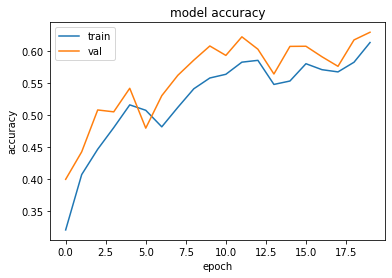

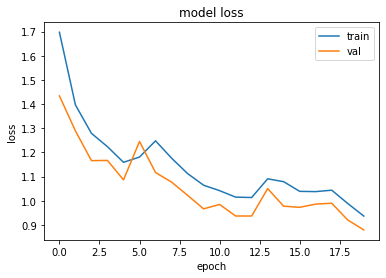

Best accuracy (on validation dataset): 62.87%
[[ 512   24    0  193    0    0   50    1]
 [  24  336    5  541    0    4   22    1]
 [   4    4  297    0    0   75    0    1]
 [  66   60    0 1136    0    0   11    0]
 [  18   26    1  303    0    0    5    0]
 [   6    2  222    0    0  118    2    5]
 [  59    8    0   14    0    0  287    0]
 [   3    0    4    0    0    3    5  314]]


<Figure size 432x288 with 0 Axes>

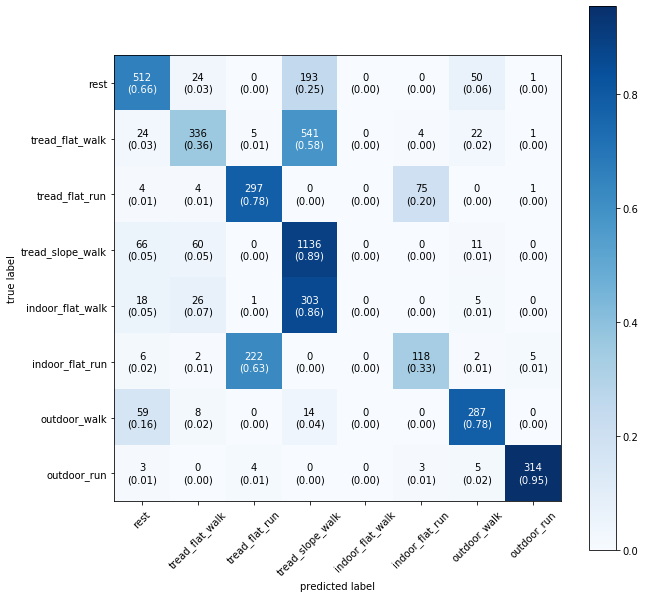

Classification Report:
                  precision    recall  f1-score   support

            rest     0.7399    0.6564    0.6957       780
 tread_flat_walk     0.7304    0.3601    0.4824       933
  tread_flat_run     0.5614    0.7795    0.6527       381
tread_slope_walk     0.5194    0.8924    0.6566      1273
indoor_flat_walk     0.0000    0.0000    0.0000       353
 indoor_flat_run     0.5900    0.3324    0.4252       355
    outdoor_walk     0.7513    0.7799    0.7653       368
     outdoor_run     0.9752    0.9544    0.9647       329

        accuracy                         0.6287      4772
       macro avg     0.6085    0.5944    0.5803      4772
    weighted avg     0.6162    0.6287    0.5925      4772



In [19]:
# Permutation starts here:
# axis_list = ['accX', 'accY', 'accZ']
# pos_list = ['LF', 'RF', 'Waist', 'Wrist']

seed        = 29
np.random.seed(seed)

split_method_list = [
    #'TrainTestSplitWithinSubject',
                    'Random',
                #    ,'DifferentSubjectsInTrainTest'
                     ]
window_list = [
    #512,
               256
               ]

wavelet_args_list = [
    {
        "type": "Y",
        "threshold": 2,
        "wavedec_options": {"wavelet": "db4", "level": 2},
        "waverec_options": {"wavelet": "db4"}
    }
#     ,    {"type": "N"}
]

window_args_list = [
#     {"type": "by_peaks", "find_peaks_options": {"prominence": 30, "height": 20}}, 
                    {"type":"with_overlap", "overlap_perc":0.5}, 
#                     {"type":"no_overlap"}
]

feature_list_list = [
    [
#      'accX_LF', 'accY_LF', 'accZ_LF', 
#      'accX_RF', 'accY_RF', 'accZ_RF'
#      ,      'accX_Waist', 'accY_Waist', 'accZ_Waist', 
        'accX_Wrist', 'accY_Wrist', 'accZ_Wrist'
    ]
]

count = 0
for split_method in split_method_list:
    for window in window_list:
        for wavelet_args in wavelet_args_list:
            for window_args in window_args_list:
                for feature_list in feature_list_list:
                    count = count + 1
                    model_name = 'model_v' + str(count)
                    
                    feature_col = feature_list[0]
                    
                    for feature in feature_list:
                        prepare_single_feature_to_csv(feature, feature_col, model_name, split_method, window,
                                                      wavelet_args, window_args)

                    X_train, y_train, X_test, y_test = load_dataset(model_name, feature_list, window, wavelet_args, window_args,
                                                                    split_method)

                    print(X_train.shape)
                    print(y_train.shape)
                    print(X_test.shape)
                    print(y_test.shape)
                    print(X_train.shape[1])
                    print(X_train.shape[2])
                    print(y_train.shape[1])


                    train_predict_plot(X_train, y_train, X_test, y_test, model_name=model_name, verbose=1, epochs=20,
                                       batch_size=300)



